# 7章 線形モデル上のバンディット問題のテスト

Author: hagino3000  
Date: 2016-11-30

「バンディット問題の理論とアルゴリズム」[1] の7章のアルゴリズムを実装して動かしてみる．

- LinUCB
- 線形モデル上のトンプソン抽出


[1] 「バンディット問題の理論とアルゴリズム」本多淳也／中村篤祥・著 http://www.kspub.co.jp/book/detail/1529175.html

## 実験データ

報酬はネット広告のCPMとする  
デザインとフォントは時刻tのコンテキスト(オーディエンス属性)に依存する，コンテキスト付きバンディット問題

In [387]:
# 真の報酬モデル
campaigns = {
    'campaign_a': 10,
    'campaign_b': 13,
    'campaign_c': 19,
    'campaign_d': 16
}
attribute = {
    'men_20': 1,
    'men_30': 50,
    'female_20': 8,
    'female_30': 20  
}
contextual_attr = {
    'design_a': 0,
    'design_b': 0,
    'font_a': 0,
    'font_b': 0
}
contextual_attrs = {
    'men_20': {
        'design': {
            'a': 20,
            'b': -1,
            'c': 16
        },
        'font': {
            'a': 10,
            'b': 5            
        }
    },
    'men_30': {
        'design': {
            'a': 5,
            'b': -1,
            'c': 3
        },
        'font': {
            'a': 10,
            'b': -1            
        }
    },
    'female_20': {
        'design': {
            'a': -20,
            'b': 40,  
            'c': 30
        },
        'font': {
            'a': 5,
            'b': -10            
        }
    }, 
    'female_30': {
        'design': {
            'a': -10,
            'b': 20, 
            'c': 15
        },
        'font': {
            'a': -5,
            'b': 3            
        }
    }
}

contextual_columns = []
contextual_values = []
for attr, attr_v in contextual_attrs.items():
    for el, el_v in attr_v.items():
        for type_name, value in el_v.items():
            contextual_columns.append(attr + '_' + el + '_' + type_name)
            contextual_values.append(value)

actions = []
for a in [campaigns.keys(), attribute.keys(), contextual_columns]:
    actions.extend(a)
theta = []
for a in [campaigns.values(), attribute.values(), contextual_values]:
    theta.extend(a)

In [388]:
# actionの要素
print(actions)

['campaign_b', 'campaign_c', 'campaign_d', 'campaign_a', 'female_20', 'men_20', 'female_30', 'men_30', 'female_20_font_b', 'female_20_font_a', 'female_20_design_c', 'female_20_design_b', 'female_20_design_a', 'men_20_font_b', 'men_20_font_a', 'men_20_design_c', 'men_20_design_b', 'men_20_design_a', 'female_30_font_b', 'female_30_font_a', 'female_30_design_c', 'female_30_design_b', 'female_30_design_a', 'men_30_font_b', 'men_30_font_a', 'men_30_design_c', 'men_30_design_b', 'men_30_design_a']


In [389]:
# 真の\theta
print(theta)

[13, 19, 16, 10, 8, 1, 20, 50, -10, 5, 30, 40, -20, 5, 10, 16, -1, 20, 3, -5, 15, 20, -10, -1, 10, 3, -1, 5]


In [390]:
# 真の分散
var = [
    64, 81, 64, 32,       # campaign (a,b,c,d)
    16, 16, 16, 16,       # ユーザー属性
    128, 128, 64, 9, 9,   # men_20
    64, 64, 64, 9, 9,     # men_30
    128, 128, 64, 16, 16, # female_20
    64, 64, 64, 16, 16    # female_30
]

In [391]:
empty_row = {}
for c in actions:
    empty_row[c] = 0

In [392]:
print(empty_row)

{'men_20_design_b': 0, 'female_20_font_b': 0, 'men_30_font_b': 0, 'men_20_font_a': 0, 'female_30': 0, 'female_20_design_c': 0, 'men_30_design_c': 0, 'female_20_font_a': 0, 'men_20_design_a': 0, 'female_30_font_b': 0, 'men_30_design_a': 0, 'men_30_font_a': 0, 'men_20_design_c': 0, 'campaign_a': 0, 'female_20': 0, 'campaign_b': 0, 'men_20_font_b': 0, 'campaign_d': 0, 'men_30_design_b': 0, 'female_30_design_b': 0, 'female_20_design_a': 0, 'female_30_design_a': 0, 'campaign_c': 0, 'female_30_design_c': 0, 'female_20_design_b': 0, 'men_20': 0, 'female_30_font_a': 0, 'men_30': 0}


In [393]:
ret = []
for k, v in campaigns.items():
    cp = k
    cp_value = v
    for k, v in attribute.items():
        attr = k
        attr_value = v
        for k, v in contextual_attrs[attr]['design'].items():
            design = k
            design_value = v
            for k, v in contextual_attrs[attr]['font'].items():
                font = k
                font_value = v
                row = empty_row.copy()
                row[cp] = 1
                row[attr] = 1
                row[attr + '_design_' + design] = 1
                row[attr + '_font_' + font] = 1
                ret.append(row)

## 選択可能なactionの組み合わせ

In [394]:
df_actions = pd.DataFrame.from_dict(ret)
df_actions = df_actions[actions]
df_actions

,campaign_b,campaign_c,campaign_d,campaign_a,female_20,men_20,female_30,men_30,female_20_font_b,female_20_font_a,...,female_30_font_b,female_30_font_a,female_30_design_c,female_30_design_b,female_30_design_a,men_30_font_b,men_30_font_a,men_30_design_c,men_30_design_b,men_30_design_a
0,1,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
5,1,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
6,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [396]:
# 真の期待値と真の分散から報酬を生成する
cov = np.identity(len(var))*var
def get_reward(action):
    return sum(np.random.multivariate_normal(action.T*theta, cov)*action)

# コンテキストの生成
contexts = [k for k in attribute.keys()]
def get_context(t):
    return contexts[t % len(contexts)]

## LinUCB

In [397]:
def linucb(T=1000, input_sigma2=600, param_sigma02=300, param_alpha=10):
    A_inv = np.matrix((param_sigma02/input_sigma2)*np.identity(len(actions)))
    b = np.zeros(len(theta))    

    # results
    rewards = []
    for t in range(1, T):
        alpha_t = param_alpha*np.sqrt(np.log(t))
        theta_hat = A_inv.A.dot(b)
        context = get_context(t)
        ucb_scores = []
        selectable_actions = []
        for i in df_actions[df_actions[context] != 0].index.values:
            a_i = df_actions.iloc[i].values
            ucb_score = a_i.dot(theta_hat) + alpha_t*np.sqrt(input_sigma2)*np.sqrt(a_i.dot(A_inv).dot(a_i))
            selectable_actions.append(a_i)
            ucb_scores.append(ucb_score)
        # 時刻tにおける行動 a_{i,t}
        a_i_t = selectable_actions[np.array(ucb_scores).argmax()]
        # 時刻tに観測した報酬
        reward = get_reward(a_i_t)
        b += a_i_t*reward
        A_inv = calc_new_a_inv(A_inv, a_i_t)
        rewards.append(reward)
    return theta_hat, np.array(rewards), b

In [398]:
theta_hat, rewards, b = linucb(T=100)

In [399]:
theta_hat

array([ 17.80499151,  20.86452981,  15.30401476,  12.49704469,
        11.81855563,  10.38224051,  15.56716363,  28.70262099,
         1.9061222 ,   9.91243343,  12.65604405,  24.59282515,
       -25.43031357,   1.75839392,   8.62384659,   6.54503175,
        -0.80774054,   4.6449493 ,  10.97112984,   4.5960338 ,
         9.08111732,  17.9346632 , -11.44861689,   9.12875298,
        19.57386801,   6.82292513,   7.15291276,  14.7267831 ])

In [400]:
b

array([ 1324.93757012,  1556.90320253,  1146.01212738,  1021.20918228,
        1102.54399024,   920.92211445,  1238.53099764,  1787.06497999,
         469.98658812,   632.55740212,   456.57583257,   644.00291919,
           1.96523848,   390.14510542,   530.77700903,   322.97836524,
         249.45064234,   348.49310688,   687.94939884,   550.5815988 ,
         461.48172384,   623.3936341 ,   153.6556397 ,   773.56888597,
        1013.49609402,   532.71453089,   548.901741  ,   705.4487081 ])

In [401]:
def run_linucb_test(T, trial, param_sigma02=300, plot=True):
    rewards_result = []
    loss_result = []
    for _ in range(trial):
        theta_hat, rewards, b = linucb(T=T, param_sigma02=param_sigma02)
        loss = sum(theta - theta_hat)
        rewards_result.append(rewards.cumsum())
        loss_result.append(loss)
    
    reward_gained_mean = np.array(rewards_result).mean(axis=0)
    if plot:
        plt.figure(figsize=(14, 2))
        plt.xlabel('time')
        plt.ylabel('Average Rewards')
        plt.plot(reward_gained_mean)
    print('Theta - ThetaHat:{}'.format(np.mean(loss_result)))
    return reward_gained_mean

Theta - ThetaHat:9.880273536849476


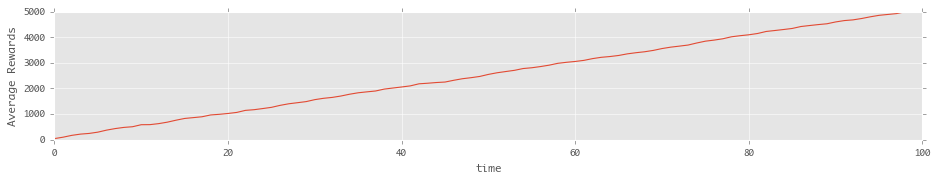

In [402]:
rewards = run_linucb_test(T=100, trial=10)

# 正規分布モデルのThompson抽出

### アルゴリズム 7.2
入力: 誤差項の分散 $\sigma^2$  
パラメータ: $\sigma_0^2 > 0$

$
A^{-1} \leftarrow \frac{\sigma^2_0}{\sigma^2}I_d.  \ //\ |a|*|a|の行列\\
b \leftarrow 0. \ //\ サイズ |a| のベクトル \\
\mathrm{for}\ t = 1,2,....,T\ \mathrm{do} \\
\hspace{10pt}\tilde{\theta}\ を多変量正規分布\ N(A^{-1}b, \sigma^2A^{-1})\ から生成. \\
\hspace{10pt}i \leftarrow argmax_i\tilde{\theta}^{\mathrm{T}}_a{i,t} を選択して報酬 X(t) を観測. \\
\hspace{10pt}A^{-1} \leftarrow A^{-1} - \frac{A^{-1}a_{i,t}^{\mathrm{T}}A^{-1}}{1 + a_{i,t}^{\mathrm{T}}A^{-1}a_{i,t}}. \\
\hspace{10pt}b \leftarrow b + a_{i,t}X(t). \\
\mathrm{end\ for}
$

In [403]:
def calc_new_a_inv(A_inv, a_i_t):
    return A_inv - (A_inv*(np.matrix(a_i_t).T)*(a_i_t)*A_inv)/(1 + a_i_t.dot(A_inv).dot(a_i_t))

In [376]:
def thompson_sampling(T=1000, input_sigma2=600, param_sigma02=300):
    A_inv = np.matrix((param_sigma02/input_sigma2)*np.identity(len(actions)))
    b = np.zeros(len(theta))

    # results
    rewards = []
    for t in range(1, T):
        theta_hat = np.random.multivariate_normal(A_inv.A.dot(b), input_sigma2*A_inv)
        context = get_context(t)
        estimated_rewards = []
        selectable_actions = []
        for i in df_actions[df_actions[context] != 0].index.values:
            a_i = df_actions.iloc[i].values
            estimated_reward = a_i.T.dot(theta_hat)
            selectable_actions.append(a_i)
            estimated_rewards.append(estimated_reward)
        # 時刻tにおける行動 a_{i,t}
        a_i_t = selectable_actions[np.array(estimated_rewards).argmax()]
        # 時刻tに観測した報酬
        reward = get_reward(a_i_t)
        b += a_i_t*reward
        A_inv = calc_new_a_inv(A_inv, a_i_t)
        rewards.append(reward)
    return theta_hat, np.array(rewards), b

In [404]:
def run_thompson_test(T, trial, param_sigma02=300, plot=True):
    rewards_result = []
    loss_result = []
    for _ in range(trial):
        theta_hat, rewards, b = thompson_sampling(T=T, param_sigma02=param_sigma02)
        loss = sum(theta - theta_hat)
        rewards_result.append(rewards.cumsum())
        loss_result.append(loss)
    
    reward_gained_mean = np.array(rewards_result).mean(axis=0)
    if plot:
        plt.figure(figsize=(14, 2))
        plt.xlabel('time')
        plt.ylabel('Average Rewards')
        plt.plot(reward_gained_mean)
    print('Theta - ThetaHat:{}'.format(np.mean(loss_result)))
    return reward_gained_mean

In [405]:
# T=50でテスト
theta_hat, rewards, b = thompson_sampling(50)

In [406]:
# 全ての項から報酬が発生している (選択した) 事を確認
b

array([  232.80379399,   112.65440728,  1885.710464  ,   161.16721287,
         482.25666648,   410.79929985,   661.41531725,   837.86459454,
         264.25500096,   218.00166552,   321.25804221,   175.06512724,
         -14.06650297,   276.02075386,   134.778546  ,    69.79129901,
          30.93631441,   310.07168643,   634.16317729,    27.25213995,
         100.22735564,   497.84744664,    63.34051496,   536.3094912 ,
         301.55510334,   399.08480527,   145.27873459,   293.50105468])

In [407]:
# t=50時点での\theta_hat
theta_hat

array([  7.69380706,  10.45237302,   3.5797059 ,   6.23588836,
        44.52538452,  15.22365764,  24.80090949,  36.61226068,
       -21.50281649,  -8.65395907,   9.44583472,   1.36467639,
       -30.48213457,  12.22984688,   2.78552968,  16.0562168 ,
       -20.03847608,  20.44233789,  31.94175608, -15.75554168,
         3.35558357,   2.0655304 ,  10.4992854 ,   4.32430969,
         9.48508532,  14.86386278,  11.79717994,  13.41999745])

Theta - ThetaHat:124.2580500033857


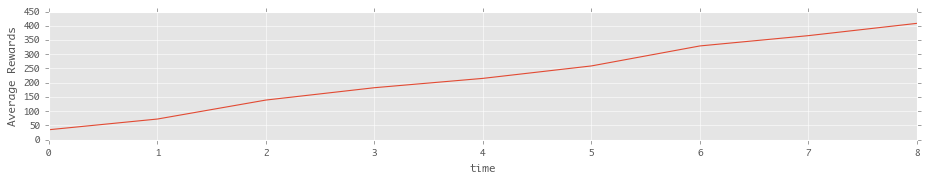

In [408]:
rewards_result = run_thompson_test(T=10, trial=20)

Theta - ThetaHat:30.31887019552019


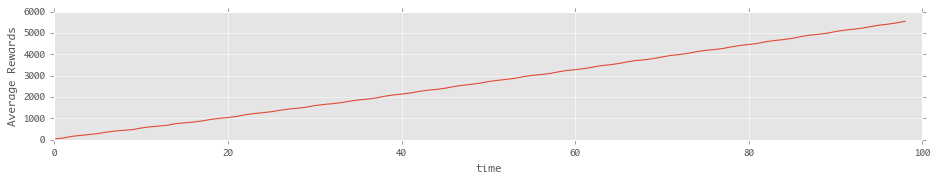

In [409]:
rewards_result = run_thompson_test(T=100, trial=20)

Theta - ThetaHat:20.22056831501493


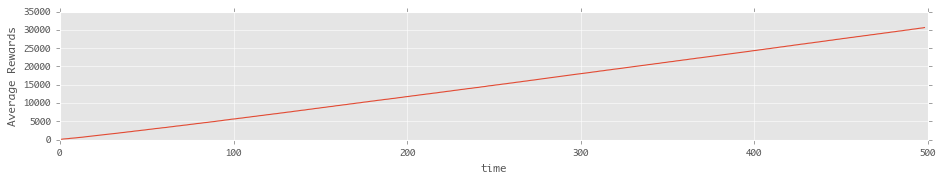

In [410]:
rewards_result = run_thompson_test(T=500, trial=20)

## 比較用のepsilon greedy実装

In [411]:
def epsilon_greedy(T=1000, epsilon=0.9):
    # results
    rewards = []
    selected_counts = np.zeros(len(df_actions))
    gained_rewards = np.zeros(len(df_actions))
    for t in range(1, T):
        context = get_context(t)
        estimated_rewards = []
        selectable_actions = []
        selectable_actions_idx = []
        for i in df_actions[df_actions[context] != 0].index.values:
            a_i = df_actions.iloc[i].values
            estimated_reward = gained_rewards[i]/selected_counts[i]
            selectable_actions.append(a_i)
            selectable_actions_idx.append(i)
            estimated_rewards.append(estimated_reward)
        # 時刻tにおける行動 a_{i,t}
        if np.random.rand() < epsilon:
            _idx = np.array(estimated_rewards).argmax()
        else:
            _idx = np.random.randint(len(selectable_actions))
        a_i_t = selectable_actions[_idx]
        action_idx = selectable_actions_idx[_idx]
        # 時刻tに観測した報酬
        reward = get_reward(a_i_t)
        rewards.append(reward)
        selected_counts[action_idx] += 1
        gained_rewards[action_idx] += reward

    return np.array(rewards), selected_counts

In [412]:
def run_epsilon_greedy_test(T, trial, plot=True):
    rewards_result = []
    selected_counts_result = []
    for _ in range(trial):
        rewards, selected_counts = epsilon_greedy(T=T)
        rewards_result.append(rewards.cumsum())
        selected_counts_result.append(selected_counts)
    
    reward_gained_mean = np.array(rewards_result).mean(axis=0)
    selected_count_mean = np.array(selected_counts_result).mean(axis=0)
    if plot:
        plt.figure(figsize=(14, 2))
        plt.xlabel('time')
        plt.ylabel('Average Rewards')
        plt.plot(reward_gained_mean)
    return reward_gained_mean, selected_count_mean

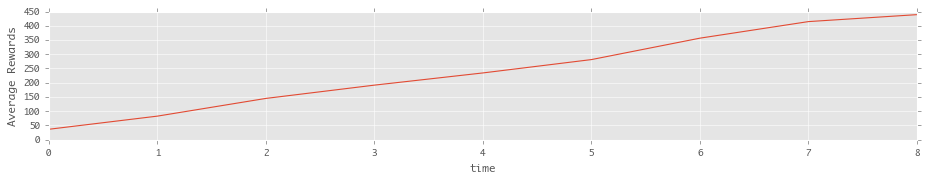

In [413]:
_, selected_count = run_epsilon_greedy_test(10, trial=20, plot=True)

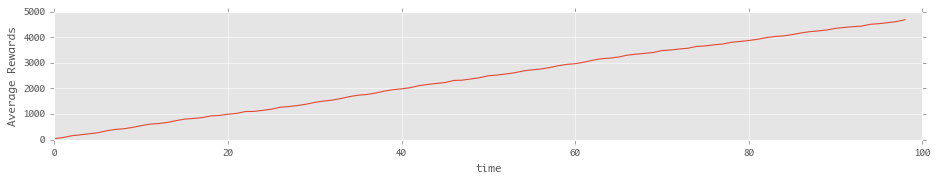

In [414]:
_, selected_count = run_epsilon_greedy_test(100, trial=20, plot=True)

In [415]:
selected_count

array([ 1.1 ,  1.15,  1.1 ,  1.15,  1.  ,  1.  ,  1.1 ,  1.15,  1.05,
        1.  ,  1.15,  1.1 ,  1.05,  1.  ,  1.15,  1.15,  1.  ,  1.  ,
        1.  ,  1.05,  1.15,  1.15,  1.  ,  1.05,  1.1 ,  1.  ,  1.  ,
        1.1 ,  1.05,  1.05,  1.  ,  1.1 ,  1.15,  1.  ,  1.15,  1.1 ,
        1.1 ,  1.  ,  1.1 ,  1.1 ,  1.05,  1.  ,  1.05,  1.  ,  1.15,
        1.15,  1.1 ,  1.2 ,  1.1 ,  1.1 ,  1.  ,  1.  ,  1.  ,  1.1 ,
        1.05,  1.  ,  1.  ,  1.05,  1.1 ,  1.  ,  1.1 ,  1.2 ,  1.05,
        1.2 ,  1.  ,  1.1 ,  1.05,  1.05,  1.1 ,  1.  ,  1.1 ,  1.05,
        1.  ,  1.  ,  1.  ,  0.9 ,  0.7 ,  0.3 ,  1.1 ,  1.  ,  1.05,
        1.  ,  0.9 ,  0.7 ,  1.  ,  1.  ,  1.  ,  1.  ,  0.8 ,  0.85,
        1.05,  1.  ,  0.95,  1.  ,  0.85,  0.75])

## 比較